## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

### 1.1 ERA5

#### 1.1.1 Data Options

In [3]:
run_data = 'era5'
variable = 'PRCP'
general_path = 'data'
start_utc = 7
end_utc = 13

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [4]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(start_utc, end_utc))[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_5hourly_era5 = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')
#dt_5hourly_era5 = dt.sum(dim='time')

### 1.2 GFS

#### 1.2.1 Data Options

In [5]:
run_data = 'gfs'
variable = 'PRCP'
general_path = 'data'
start_utc = 3
end_utc = 9

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

# data path
data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

In [6]:
# open data
dt = xr.open_mfdataset(data_path,
                       concat_dim='ens').isel(time=slice(start_utc, end_utc))[variable]

# instead of 201 grid we want 200 grid in each direction
dt = dt.isel(south_north=slice(0,200),
             west_east=slice(0,200))

# assign projection and dim info
dt = dt.rio.write_crs(dt.attrs['pyproj_srs'])
dt_5hourly_gfs = dt.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')
#dt_5hourly_gfs = dt.sum(dim='time')

## 2. Define Ensemble Members

In [7]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

## 3. Precipitation Difference Within Urban Boundaries

### 3.1 Vectorize Tiff Data

In [8]:
gg = rioxarray.open_rasterio('data/lu_index/urban_luse_border_raster.tiff').squeeze('band', drop=True)

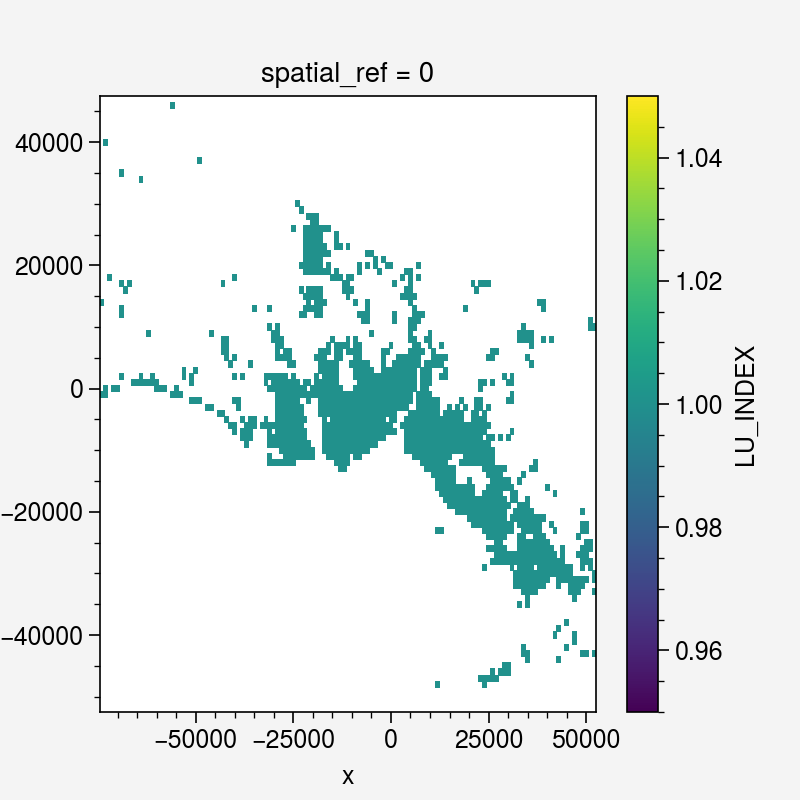

In [9]:
gg.plot()

In [10]:
gg = gg.rio.write_crs(dt.rio.crs)
gdf = xr_vectorize(gg,
                   crs=gg.rio.crs,
                   mask=gg.values==1)

<AxesSubplot:>

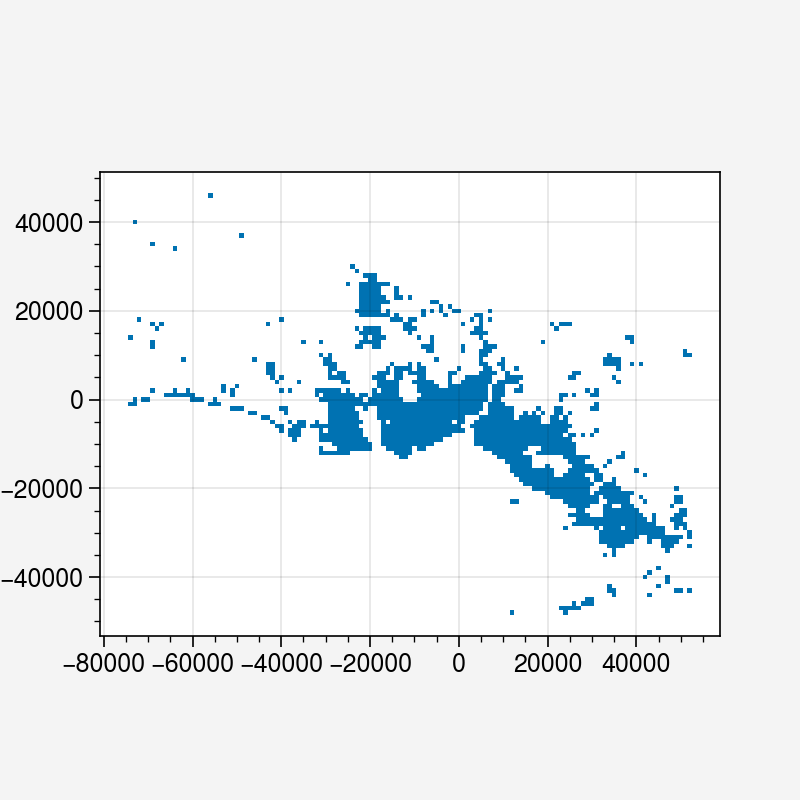

In [11]:
gdf.plot()

In [12]:
def clip_to_city(data, shapefile, crs_data, x_dims, y_dims):
    
    data= data.rio.set_spatial_dims(x_dim=x_dims, y_dim=y_dims)

    data = data.rio.write_crs(crs_data)
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [13]:
x_dims = 'west_east'
y_dims = 'south_north'

In [14]:
def calculate_perc_diff(dt_urb, dt_nourb,
                        gdf, x_dims, y_dims,
                        method = 'max'):
    
    dt_urban_ens_clip = clip_to_city(dt_urb, gdf, 
                                 dt.rio.crs, 
                                 x_dims,
                                 y_dims)

    dt_nourban_ens_clip = clip_to_city(dt_nourb, gdf, 
                                     dt.rio.crs, 
                                     x_dims,
                                     y_dims)
    
    method_dict = {
        'max': [dt_urban_ens_clip.max, dt_nourban_ens_clip.max],
        'sum': [dt_urban_ens_clip.sum, dt_nourban_ens_clip.sum],
        
    }

    # grid sums of precipitation within urban boundary
    urban_grid_total = method_dict[method][0](dim=[x_dims, y_dims]).compute().values
    nourban_grid_total = method_dict[method][1](dim=[x_dims, y_dims]).compute().values
    
    # percentage difference for the 5 hour period
    perc_diff = (urban_grid_total-nourban_grid_total)/nourban_grid_total*100
    
    return perc_diff

### 3.2 Clip WRF Data to Shapefile and Find Percent Difference

#### 3.2.1 ERA5

In [15]:
era5_max_perc_diff = {}
era5_sum_perc_diff = {}

for i, (urb_ens, nourb_ens) in enumerate(zip(urban_members, nourban_members)):
    
    print(urb_ens)
    print(nourb_ens)
    
    # calculate max
    max_perc_diff = calculate_perc_diff(dt_5hourly_era5.sel(ens=urb_ens),
                                        dt_5hourly_era5.sel(ens=nourb_ens),
                                        gdf, x_dims, y_dims,
                                        method = 'max')
    # calculate sum
    sum_perc_diff = calculate_perc_diff(dt_5hourly_era5.sel(ens=urb_ens),
                                        dt_5hourly_era5.sel(ens=nourb_ens),
                                        gdf, x_dims, y_dims,
                                        method = 'sum')
    
    era5_max_perc_diff[fr'era5_{micro_options[i]}_max'] = max_perc_diff
    era5_sum_perc_diff[fr'era5_{micro_options[i]}_sum'] = sum_perc_diff

LIN_urban_PRCP
LIN_nourban_PRCP
THOMPSON_urban_PRCP
THOMPSON_nourban_PRCP
WSM6_urban_PRCP
WSM6_nourban_PRCP


In [16]:
# turn to pd df
pd_era5_max_perc_diff = pd.DataFrame(era5_max_perc_diff)
pd_era5_sum_perc_diff = pd.DataFrame(era5_sum_perc_diff)

# concat max and sum df
era5_diff_pd = pd.concat([pd_era5_max_perc_diff, pd_era5_sum_perc_diff], axis=1)

#### 3.2.2 GFS

In [17]:
gfs_max_perc_diff = {}
gfs_sum_perc_diff = {}

for i, (urb_ens, nourb_ens) in enumerate(zip(urban_members, nourban_members)):
    
    print(urb_ens)
    print(nourb_ens)
    
    # calculate max
    max_perc_diff = calculate_perc_diff(dt_5hourly_gfs.sel(ens=urb_ens),
                                        dt_5hourly_gfs.sel(ens=nourb_ens),
                                        gdf, x_dims, y_dims,
                                        method = 'max')
    # calculate sum
    sum_perc_diff = calculate_perc_diff(dt_5hourly_gfs.sel(ens=urb_ens),
                                        dt_5hourly_gfs.sel(ens=nourb_ens),
                                        gdf, x_dims, y_dims,
                                        method = 'sum')
    
    gfs_max_perc_diff[fr'gfs_{micro_options[i]}_max'] = max_perc_diff
    gfs_sum_perc_diff[fr'gfs_{micro_options[i]}_sum'] = sum_perc_diff

LIN_urban_PRCP
LIN_nourban_PRCP
THOMPSON_urban_PRCP
THOMPSON_nourban_PRCP
WSM6_urban_PRCP
WSM6_nourban_PRCP


In [18]:
# turn to pd df
pd_gfs_max_perc_diff = pd.DataFrame(gfs_max_perc_diff)
pd_gfs_sum_perc_diff = pd.DataFrame(gfs_sum_perc_diff)

# concat max and sum df
gfs_diff_pd = pd.concat([pd_gfs_max_perc_diff, pd_gfs_sum_perc_diff], axis=1)

#### 3.2.3 Complete Table

In [19]:
diff_pd = pd.concat([era5_diff_pd, gfs_diff_pd], axis=1)

### 3.3 Apply Diff Method to Ensemble Mean Data

In [20]:
dt_5hourly_era5_urban_ens = dt_5hourly_era5.sel(ens=urban_members).mean(dim='ens')
dt_5hourly_era5_nourban_ens = dt_5hourly_era5.sel(ens=nourban_members).mean(dim='ens')

dt_5hourly_gfs_urban_ens = dt_5hourly_gfs.sel(ens=urban_members).mean(dim='ens')
dt_5hourly_gfs_nourban_ens = dt_5hourly_gfs.sel(ens=nourban_members).mean(dim='ens')

#### 3.3.1 ERA5

In [21]:
ens_era5_max_perc_diff = {}
ens_era5_sum_perc_diff = {}

# calculate max
max_perc_diff = calculate_perc_diff(dt_5hourly_era5_urban_ens,
                                    dt_5hourly_era5_nourban_ens,
                                    gdf, x_dims, y_dims,
                                    method = 'max')
# calculate sum
sum_perc_diff = calculate_perc_diff(dt_5hourly_era5_urban_ens,
                                    dt_5hourly_era5_nourban_ens,
                                    gdf, x_dims, y_dims,
                                    method = 'sum')

ens_era5_max_perc_diff[fr'era5_ens_max'] = max_perc_diff
ens_era5_sum_perc_diff[fr'era5_ens_sum'] = sum_perc_diff

In [22]:
# turn to pd df
ens_pd_era5_max_perc_diff = pd.DataFrame(ens_era5_max_perc_diff)
ens_pd_era5_sum_perc_diff = pd.DataFrame(ens_era5_sum_perc_diff)

# concat max and sum df
ens_era5_diff_pd = pd.concat([ens_pd_era5_max_perc_diff, ens_pd_era5_sum_perc_diff], axis=1)

#### 3.3.2 GFS

In [23]:
ens_gfs_max_perc_diff = {}
ens_gfs_sum_perc_diff = {}

# calculate max
max_perc_diff = calculate_perc_diff(dt_5hourly_gfs_urban_ens,
                                    dt_5hourly_gfs_nourban_ens,
                                    gdf, x_dims, y_dims,
                                    method = 'max')
# calculate sum
sum_perc_diff = calculate_perc_diff(dt_5hourly_gfs_urban_ens,
                                    dt_5hourly_gfs_nourban_ens,
                                    gdf, x_dims, y_dims,
                                    method = 'sum')

ens_gfs_max_perc_diff[fr'gfs_ens_max'] = max_perc_diff
ens_gfs_sum_perc_diff[fr'gfs_ens_sum'] = sum_perc_diff

In [24]:
# turn to pd df
ens_pd_gfs_max_perc_diff = pd.DataFrame(ens_gfs_max_perc_diff)
ens_pd_gfs_sum_perc_diff = pd.DataFrame(ens_gfs_sum_perc_diff)

# concat max and sum df
ens_gfs_diff_pd = pd.concat([ens_pd_gfs_max_perc_diff, ens_pd_gfs_sum_perc_diff], axis=1)

#### 3.3.3 Complete Table

In [25]:
ens_diff_pd = pd.concat([ens_era5_diff_pd, ens_gfs_diff_pd], axis=1)

In [26]:
ens_diff_pd

,era5_ens_max,era5_ens_sum,gfs_ens_max,gfs_ens_sum
0,70.244385,70.906303,45.177261,26.688963
1,111.018692,80.202171,114.284111,97.626381
2,32.472889,28.497583,-22.999575,5.731963
3,-6.639081,-1.367764,18.923370,13.952462
4,3.559734,-33.550915,2.057211,89.666435
5,-20.682104,-50.070339,33.757397,45.806522


### 3.4 Merge Microphysics Table and Ensemble Mean Table

In [27]:
complete_table = pd.concat([ens_diff_pd, diff_pd], axis=1)

In [28]:
# order to make more readable
microphysics_order = [
    'era5_ens_max',
    'era5_ens_sum',
    'gfs_ens_max',
    'gfs_ens_sum',
    #'era5_LIN_max',
    #'era5_LIN_sum',
    #'era5_THOMPSON_max',
    #'era5_THOMPSON_sum',
    #'era5_WSM6_max',
    #'era5_WSM6_sum',
    #'gfs_LIN_max',
    #'gfs_LIN_sum',
    #'gfs_THOMPSON_max',
    #'gfs_THOMPSON_sum',
    #'gfs_WSM6_max',
    #'gfs_WSM6_sum',
]

complete_table = complete_table[microphysics_order]

In [29]:
complete_table

,era5_ens_max,era5_ens_sum,gfs_ens_max,gfs_ens_sum
0,70.244385,70.906303,45.177261,26.688963
1,111.018692,80.202171,114.284111,97.626381
2,32.472889,28.497583,-22.999575,5.731963
3,-6.639081,-1.367764,18.923370,13.952462
4,3.559734,-33.550915,2.057211,89.666435
5,-20.682104,-50.070339,33.757397,45.806522


## 4. Precipitation Difference Within Istanbul Boundaries

In [30]:
# open istanbul boundary
ist_shape = r'data/shapefiles/istanbul_province_borders.shp'
gdf_ist = gpd.read_file(ist_shape)

<AxesSubplot:>

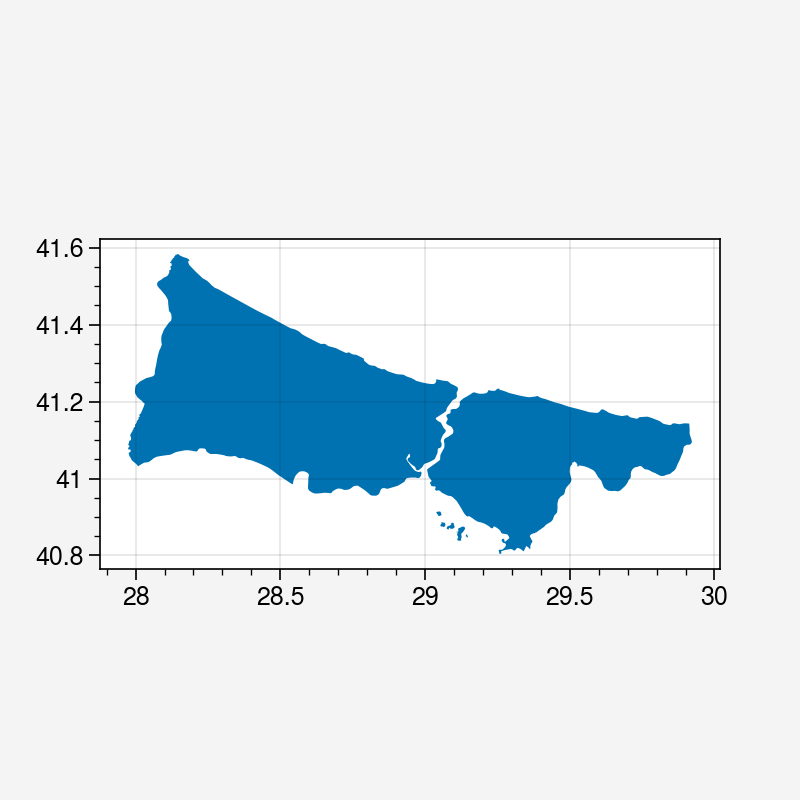

In [31]:
gdf_ist.plot()

### 4.1 ERA5

In [32]:
ens_era5_max_perc_diff = {}
ens_era5_sum_perc_diff = {}

# calculate max
max_perc_diff = calculate_perc_diff(dt_5hourly_era5_urban_ens,
                                    dt_5hourly_era5_nourban_ens,
                                    gdf_ist, x_dims, y_dims,
                                    method = 'max')
# calculate sum
sum_perc_diff = calculate_perc_diff(dt_5hourly_era5_urban_ens,
                                    dt_5hourly_era5_nourban_ens,
                                    gdf_ist, x_dims, y_dims,
                                    method = 'sum')

ens_era5_max_perc_diff[fr'era5_ens_max'] = max_perc_diff
ens_era5_sum_perc_diff[fr'era5_ens_sum'] = sum_perc_diff

In [33]:
# turn to pd df
ens_pd_era5_max_perc_diff = pd.DataFrame(ens_era5_max_perc_diff)
ens_pd_era5_sum_perc_diff = pd.DataFrame(ens_era5_sum_perc_diff)

# concat max and sum df
ens_era5_diff_pd = pd.concat([ens_pd_era5_max_perc_diff, ens_pd_era5_sum_perc_diff], axis=1)

### 4.2 GFS

In [34]:
ens_gfs_max_perc_diff = {}
ens_gfs_sum_perc_diff = {}

# calculate max
max_perc_diff = calculate_perc_diff(dt_5hourly_gfs_urban_ens,
                                    dt_5hourly_gfs_nourban_ens,
                                    gdf_ist, x_dims, y_dims,
                                    method = 'max')
# calculate sum
sum_perc_diff = calculate_perc_diff(dt_5hourly_gfs_urban_ens,
                                    dt_5hourly_gfs_nourban_ens,
                                    gdf_ist, x_dims, y_dims,
                                    method = 'sum')

ens_gfs_max_perc_diff[fr'gfs_ens_max'] = max_perc_diff
ens_gfs_sum_perc_diff[fr'gfs_ens_sum'] = sum_perc_diff

In [35]:
# turn to pd df
ens_pd_gfs_max_perc_diff = pd.DataFrame(ens_gfs_max_perc_diff)
ens_pd_gfs_sum_perc_diff = pd.DataFrame(ens_gfs_sum_perc_diff)

# concat max and sum df
ens_gfs_diff_pd = pd.concat([ens_pd_gfs_max_perc_diff, ens_pd_gfs_sum_perc_diff], axis=1)

### 4.3 Complete Table

In [36]:
ens_diff_pd = pd.concat([ens_era5_diff_pd, ens_gfs_diff_pd], axis=1)

In [37]:
ens_diff_pd

,era5_ens_max,era5_ens_sum,gfs_ens_max,gfs_ens_sum
0,81.443382,49.631012,22.405483,0.917881
1,7.090553,37.743412,73.990448,40.448116
2,16.953188,19.729633,-22.999575,19.980715
3,-6.114419,-1.330403,-13.260801,0.271437
4,-11.480900,-18.253483,-19.131363,22.931049
5,-32.891422,-47.274399,-12.929855,16.684732
